In [1]:
!pip install git+https://github.com/desi-bgs/bgs-cmxsv.git --upgrade --user

  Cloning https://github.com/desi-bgs/bgs-cmxsv.git to /tmp/pip-req-build-u9bwplax
  Running command git clone -q https://github.com/desi-bgs/bgs-cmxsv.git /tmp/pip-req-build-u9bwplax
  Created wheel for bgs-sv: filename=bgs_sv-0.0-py3-none-any.whl size=1057850 sha256=e07f62431281bae2681075d75b593ed8f1353375f11a42e52c63d374af050ff8
  Stored in directory: /tmp/pip-ephem-wheel-cache-67a0mjp_/wheels/c5/7b/33/3fa8f7338087a37e7ad7a1378e08d97458e5dbab577a10268f
Successfully built bgs-sv
  Attempting uninstall: bgs-sv
    Found existing installation: bgs-sv 0.0
    Uninstalling bgs-sv-0.0:
      Successfully uninstalled bgs-sv-0.0


In [2]:
import numpy as np 
import astropy.table as atable
import matplotlib.pyplot as plt

from bgs_sv import sv1

# read single exposures from Blanc reduction
Mike Wilson is currently running redrock outputs for single exposures

In [3]:
exps = sv1.blanc_nexp1_exposures()

In [4]:
# lets only keep the nightly exposures where we have a corresponding 
# deep exposure that we can use as the truth table
deep_exp = sv1.blanc_deep_exposures()

keep = np.zeros(len(exps)).astype(bool)
for i in range(len(exps)): 
    if exps[i]['TILEID'] in deep_exp['TILEID']: 
        keep[i] = True
print('%i exposures with corresponding deep exposures' % np.sum(keep))

175 exposures with corresponding deep exposures


In [5]:
exps[keep]

NIGHT,EXPID,TILEID,TILERA,TILEDEC,EXPTIME,MJDOBS,FIELD,TARGETS,EBV,SPECMODEL_SKY_RMAG_AB,NGFA,B_DEPTH,R_DEPTH,Z_DEPTH,TGT,SKY,STD,WD,LRG,ELG,QSO,BGS,MWS,GFA_AIRMASS_MIN,GFA_AIRMASS_MEAN,GFA_AIRMASS_MED,GFA_AIRMASS_MAX,GFA_MOON_ILLUMINATION_MIN,GFA_MOON_ILLUMINATION_MEAN,GFA_MOON_ILLUMINATION_MED,GFA_MOON_ILLUMINATION_MAX,GFA_MOON_ZD_DEG_MIN,GFA_MOON_ZD_DEG_MEAN,GFA_MOON_ZD_DEG_MED,GFA_MOON_ZD_DEG_MAX,GFA_MOON_SEP_DEG_MIN,GFA_MOON_SEP_DEG_MEAN,GFA_MOON_SEP_DEG_MED,GFA_MOON_SEP_DEG_MAX,GFA_TRANSPARENCY_MIN,GFA_TRANSPARENCY_MEAN,GFA_TRANSPARENCY_MED,GFA_TRANSPARENCY_MAX,GFA_FWHM_ASEC_MIN,GFA_FWHM_ASEC_MEAN,GFA_FWHM_ASEC_MED,GFA_FWHM_ASEC_MAX,GFA_SKY_MAG_AB_MIN,GFA_SKY_MAG_AB_MEAN,GFA_SKY_MAG_AB_MED,GFA_SKY_MAG_AB_MAX,GFA_FIBER_FRACFLUX_MIN,GFA_FIBER_FRACFLUX_MEAN,GFA_FIBER_FRACFLUX_MED,GFA_FIBER_FRACFLUX_MAX,GFA_FIBER_FRACFLUX_ELG_MIN,GFA_FIBER_FRACFLUX_ELG_MEAN,GFA_FIBER_FRACFLUX_ELG_MED,GFA_FIBER_FRACFLUX_ELG_MAX,GFA_TRANSPFRAC_MIN,GFA_TRANSPFRAC_MEAN,GFA_TRANSPFRAC_MED,GFA_TRANSPFRAC_MAX
int64,int64,int64,float32,float32,float32,float32,bytes30,bytes8,float32,float32,int64,float32,float32,float32,int64,int64,int64,int64,int64,int64,int64,int64,int64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32
20201214,67765,80607,106.74,56.1,900.089,59198.332,Lynx,QSO+LRG,0.05,21.489204,125,385.8,344.2,371.3,4199,800,150,12,1922,1212,1684,380,208,1.1041484,1.1083817,1.1082504,1.1134448,0.006073797,0.0061894623,0.006189212,0.0063000005,171.68413,172.29503,172.36934,172.61827,148.39006,148.3936,148.39363,148.39374,0.9321701,0.9655009,0.9669674,0.9982807,1.1449482,1.5735582,1.5077897,2.3819253,20.995792,20.536133,20.523823,20.39603,0.18123527,0.3492944,0.35925955,0.5077853,0.15825935,0.27551404,0.28353634,0.37690264,0.1689421,0.33790332,0.34763667,0.49000615
20201214,67766,80607,106.74,56.1,900.069,59198.348,Lynx,QSO+LRG,0.05,21.444756,121,380.4,328.6,340.9,4199,800,150,12,1922,1212,1684,380,208,1.0978621,1.1001469,1.1000175,1.1031283,0.0063320235,0.0064476887,0.006447373,0.006558176,169.14215,170.38245,170.41928,171.53148,148.45491,148.45872,148.45876,148.45883,0.9303596,0.9647931,0.9655702,0.9849499,1.1986407,1.5429121,1.519951,2.0802743,20.784782,20.668648,20.67182,20.574413,0.22432755,0.35053572,0.35212016,0.47498247,0.19065095,0.27696708,0.27852526,0.35674483,0.20870529,0.33848396,0.34158522,0.46501502
20201214,67768,80607,106.74,56.1,900.078,59198.37,Lynx,QSO+LRG,0.05,21.470016,115,600.5,518.8,530.4,4199,800,150,12,1922,1212,1684,380,208,1.0958477,1.0965472,1.0964174,1.0977465,0.0068367175,0.0069560097,0.006955887,0.007070233,162.41821,164.06673,164.07545,165.76265,148.57555,148.57954,148.57957,148.57968,0.9500504,0.9715066,0.97189766,0.9893319,1.1104317,1.304,1.2661536,1.9347488,20.660788,20.566956,20.570595,20.481451,0.24591284,0.4330384,0.44205096,0.5077505,0.2050308,0.32976818,0.33656344,0.37691274,0.2336296,0.42094368,0.43163538,0.500158
20201214,67769,80608,106.74,56.2,900.089,59198.387,Lynx,ELG,0.05,21.366251,115,613.2,565.8,598.6,4195,800,125,14,21,4070,211,17,120,1.0990113,1.1015513,1.101427,1.1045214,0.007096255,0.007218224,0.0072184224,0.007335133,158.70839,160.42815,160.42818,162.21317,148.54262,148.54637,148.5464,148.54648,0.95303637,0.9737887,0.97314054,0.99796885,1.0622787,1.2191623,1.1725652,1.6560266,20.506432,20.369537,20.375143,20.272211,0.31402314,0.47148314,0.49145904,0.54397297,0.25370014,0.3541735,0.36732674,0.39959362,0.30073515,0.45940763,0.47635433,0.5371452
20201214,67770,80608,106.74,56.2,900.014,59198.4,Lynx,ELG,0.05,21.313778,113,504.6,450.7,466.4,4195,800,125,14,21,4070,211,17,120,1.1053013,1.1097201,1.1095445,1.1145134,0.0073607615,0.0074847564,0.0074833916,0.0076042432,154.919,156.67946,156.69716,158.50955,148.60039,148.60413,148.60416,1

# read redrock output for nightly combined exposures

In [9]:
zbest_deep = sv1.get_zbest(80614, 'deep', targetclass='brightfaint')
zbest_exp = sv1.get_zbest(80614, 20201218, expid=68685, targetclass='brightfaint')

In [10]:
zbest_deep[:5]

TARGETID,CHI2,COEFF [10],Z,ZERR,ZWARN,NPIXELS,SPECTYPE,SUBTYPE,NCOEFF,DELTACHI2,NUMEXP,NUMTILE,TARGET_RA,TARGET_DEC,FLUX_R,FIBERFLUX_R,PHOTSYS,SV1_DESI_TARGET,SV1_BGS_TARGET,DESI_TARGET,BGS_TARGET
int64,float64,float64,float64,float64,int64,int64,str6,str20,int64,float64,int32,int32,float64,float64,float32,float32,str1,int64,int64,int64,int64
39627714830796549,8699.758542977273,519.5417256005142 .. 3.973567050913664,0.46998040523963713,0.00010169554079946927,0,7927,GALAXY,,10,345.1201138049364,0,1,153.83374311555582,-2.918718015557949,16.74688,4.9915586,S,1152921504732676217,131074,0,0
39627714830796890,8222.362058758736,634.2726683959203 .. 6.0222258843620144,0.15535415669251315,9.690354826903852e-06,0,7924,GALAXY,,10,571.3116875886917,0,1,153.8500677385002,-2.8897959874514996,69.457016,4.8695545,S,1152921504606846976,131074,0,0
39627714830798488,78411.57190588662,-23407.87256614676 .. 0.0,9.521301684159149e-05,9.540514547596102e-07,0,7928,STAR,M,5,291614.25069432904,0,1,153.9347820085281,-2.9087333147209193,24.139637,18.764397,S,1152921504724287601,655370,0,0
39627714830799406,8213.99819546938,279.7710801582137 .. 2.361403086985407,0.1801377451973022,8.196952424934093e-06,0,7882,GALAXY,,10,478.1733047366142,0,1,153.97810731977967,-2.8763995527609256,21.574492,2.368062,S,1152921504606846976,131074,0,0
39627714830799666,9746.891668915749,320.0010312461728 .. 15.592757344317615,0.22205998798163412,7.596184103271948e-06,0,7926,GALAXY,,10,3054.0358518362045,0,1,153.99196226506743,-2.917748140366553,14.996162,6.5504346,S,1152921504606846976,131074,0,0


In [11]:
zbest_exp[:5]

TARGETID,CHI2,COEFF [10],Z,ZERR,ZWARN,NPIXELS,SPECTYPE,SUBTYPE,NCOEFF,DELTACHI2,NUMEXP,NUMTILE,TARGET_RA,TARGET_DEC,FLUX_R,FIBERFLUX_R,PHOTSYS,SV1_DESI_TARGET,SV1_BGS_TARGET,DESI_TARGET,BGS_TARGET
int64,float64,float64,float64,float64,int64,int64,str6,str20,int64,float64,int32,int32,float64,float64,float32,float32,str1,int64,int64,int64,int64
39627714830796549,7859.8412348516285,567.0931554866448 .. -0.7718901864579057,0.4697102201550656,0.00010310238318256176,0,7884,GALAXY,,10,47.1124422699213,0,0,153.83374311555582,-2.918718015557949,16.74688,4.9915586,S,1152921504732676217,131074,0,0
39627714830796890,7897.751856148243,979.9358836102559 .. 12.76202965995219,0.15533360226410203,1.6694136072995987e-05,0,7877,GALAXY,,10,170.78858715295792,0,0,153.8500677385002,-2.8897959874514996,69.457016,4.8695545,S,1152921504606846976,131074,0,0
39627714830798488,26158.290692534032,-24742.136890880243 .. 0.0,9.575607984388288e-05,1.827599563459461e-06,0,7894,STAR,M,5,75523.16169366639,0,0,153.9347820085281,-2.9087333147209193,24.139637,18.764397,S,1152921504724287601,655370,0,0
39627714830799406,7647.569525182247,-31.352826052223914 .. -8.258401002084284,0.18014007015204472,1.4483077765737179e-05,0,7857,GALAXY,,10,155.83033269643784,0,0,153.97810731977967,-2.8763995527609256,21.574492,2.368062,S,1152921504606846976,131074,0,0
39627714830799666,7992.132884144783,221.85404548125038 .. 5.110731163577474,0.2221439714945326,1.6260743102612657e-05,0,7895,GALAXY,,10,862.6834602355957,0,0,153.99196226506743,-2.917748140366553,14.996162,6.5504346,S,1152921504606846976,131074,0,0


# caclulate $z$ success rate using the deep exposures as the truth table

In [12]:
def zsuccess_redrock_criteria(zbest): 
    ''' redshift success criteria based only on redrock output
    '''
    crit_zwarn = (zbest['ZWARN'] == 0)
    crit_dchi2 = (zbest['DELTACHI2']  > 40.) 
    crit_stype = (zbest['SPECTYPE'] != "STAR") # only galaxy spectra
    crit_z_lim = (zbest['Z'] > 0.0) & (zbest['Z'] < 0.6) # rough BGS redshift limit
    crit_z_err = (zbest['ZERR'] < (0.0005 * (1. + zbest['Z'])))

    # combine all criteria
    zsuccess = crit_zwarn & crit_dchi2 & crit_stype & crit_z_lim & crit_z_err
    return zsuccess

def zsuccess_truth_criteria(zbest, z_true, silent=True): 
    ''' redshift success criteria based on redrock output *and* comparison
    to "true" redshift
    '''
    crit_zwarn = (zbest['ZWARN'] == 0)
    crit_dchi2 = (zbest['DELTACHI2']  > 40.) 
    crit_stype = (zbest['SPECTYPE'] != "STAR") # only galaxy spectra
    crit_z_lim = (zbest['Z'] > 0.0) & (zbest['Z'] < 0.6) # rough BGS redshift limit
    crit_z_err = (zbest['ZERR'] < (0.0005 * (1. + zbest['Z'])))
    
    dz_1pz = np.abs(z_true - zbest['Z']) / (1. + z_true)
    crit_ztrue = (dz_1pz < 0.003)

    # combine all criteria
    zsuccess = crit_zwarn & crit_dchi2 & crit_stype & crit_z_lim & crit_z_err & crit_ztrue
    if not silent: 
        print('%i of %i pass the redshift success criteria' % (np.sum(zsuccess), len(zsuccess)))
        print('%.2f redshift success rate' % (np.sum(zsuccess)/len(zsuccess)))
    return zsuccess

In [13]:
def zsuccess_rate(prop, zsuccess_cond, range=None, nbins=20, bin_min=2):
    ''' measure the redshift success rate along with property `prop`

    :params prop: 
        array of properties (i.e. Legacy r-band magnitude) 

    :params zsuccess_cond:
        boolean array indicating redshift success 

    :params range: (default: None) 
        range of the `prop` 

    :params nbins: (default: 20) 
        number of bins to divide `prop` by 
    
    :params bin_min: (default: 2)  
        minimum number of objects in bin to exlcude it 

    :return wmean: 
        weighted mean of `prop` in the bins 

    :return e1: 
        redshift success rate in the bins

    :return ee1: 
        simple poisson error on the success rate
    '''
    h0, bins = np.histogram(prop, bins=nbins, range=range)
    hv, _ = np.histogram(prop, bins=bins, weights=prop)
    h1, _ = np.histogram(prop[zsuccess_cond], bins=bins)
    
    good = h0 > bin_min
    hv = hv[good]
    h0 = h0[good]
    h1 = h1[good]

    wmean = hv / h0 # weighted mean 
    rate = h1.astype("float") / (h0.astype('float') + (h0==0))
    e_rate = np.sqrt(rate * (1 - rate)) / np.sqrt(h0.astype('float') + (h0 == 0))
    return wmean, rate, e_rate

In [14]:
# only use targets where we have accurate redshifts in the deep exposure
_zbest_deep = sv1.get_zbest(80614, 'deep', targetclass='brightfaint')
zs_deep = zsuccess_redrock_criteria(_zbest_deep)

zbest_deep = _zbest_deep[zs_deep]['TARGETID', 'Z']
zbest_deep.rename_column('Z', 'Z_TRUE') # deep exposure redshift is the "true redshift"

In [15]:
_zbest_exp = sv1.get_zbest(80614, 20201218, expid=68685, targetclass='brightfaint')
zbest_exp = atable.join(zbest_deep, _zbest_exp, keys='TARGETID', join_type='left')

In [16]:
# calculate redshift successs rate
zs_exp = zsuccess_truth_criteria(zbest_exp, zbest_exp['Z_TRUE'])

Text(0, 0.5, '$z$ success rate')

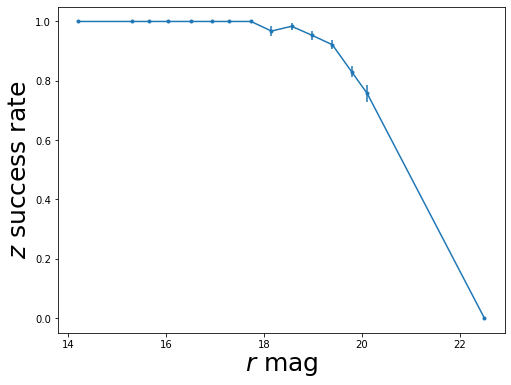

In [17]:
r_mag = 22.5 - 2.5 * np.log10(zbest_exp['FLUX_R'])
r_mid, zs, zs_err = zsuccess_rate(r_mag, zs_exp)

fig = plt.figure(figsize=(8,6))
sub = fig.add_subplot(111)
sub.errorbar(r_mid, zs, yerr=zs_err, fmt='.C0')
sub.plot(r_mid, zs)
sub.set_xlabel('$r$ mag', fontsize=25)
sub.set_ylabel('$z$ success rate', fontsize=25)

# redshift success for the single exposures for all tiles with deep exposure

In [18]:
#for tileid in [80612, 80613, 80614, 80616, 80617, 80618, 80619]: 
zss_tiles, iexps_tiles = [], [] 
for tileid in deep_exp['TILEID']: 
    # only use targets where we have accurate redshifts in the deep exposure
    try: 
        _zbest_deep = sv1.get_zbest(tileid, 'deep', targetclass='brightfaint');
    except:
        continue 
    zs_deep = zsuccess_redrock_criteria(_zbest_deep)
    
    zbest_deep = _zbest_deep[zs_deep]['TARGETID', 'Z']
    zbest_deep.rename_column('Z', 'Z_TRUE') # deep exposure redshift is the "true redshift"
    
    if len(zbest_deep) < 200: continue
    
    zss, iexps = [], []
    nights = np.unique(exps['NIGHT'][exps['TILEID'] == tileid])
    for i, night in enumerate(nights): 
        expids = np.unique(exps['EXPID'][(exps['TILEID'] == tileid) & (exps['NIGHT'] == night)])
        for ii, expid in enumerate(expids): 
            # only look at TRANSP > 0.9 with GFA SKY MAG < 20.075
            iexp = np.where(exps['EXPID'] == expid)[0]
            if exps['GFA_TRANSPARENCY_MED'][iexp] <= 0.9:# or exps['GFA_SKY_MAG_AB_MED'][isexp] > 20.075:
                continue 
            try: 
                _zbest_exp = sv1.get_zbest(tileid, night, expid=expid, targetclass='brightfaint');
            except: 
                continue
            zbest_exp = atable.join(zbest_deep, _zbest_exp, keys='TARGETID', join_type='inner')

            # calculate redshift successs rate
            zs_exp = zsuccess_truth_criteria(zbest_exp, zbest_exp['Z_TRUE'])

            r_mag = 22.5 - 2.5 * np.log10(zbest_exp['FLUX_R'])
            zss.append(zsuccess_rate(r_mag, zs_exp, range=[17.5, 20.5]))
            iexps.append(iexp)
    if len(zss) > 0:
        zss_tiles.append(zss)
        iexps_tiles.append(iexps)

 /global/cscratch1/sd/mjwilson/desi/SV1/spectra/exposures/NEXP1/80605/20201215/zbest-20201215-0-00067972.fits does not exist
 /global/cscratch1/sd/mjwilson/desi/SV1/spectra/exposures/NEXP1/80605/20201215/zbest-20201215-1-00067972.fits does not exist
 /global/cscratch1/sd/mjwilson/desi/SV1/spectra/exposures/NEXP1/80605/20201215/zbest-20201215-2-00067972.fits does not exist
 /global/cscratch1/sd/mjwilson/desi/SV1/spectra/exposures/NEXP1/80605/20201215/zbest-20201215-3-00067972.fits does not exist
 /global/cscratch1/sd/mjwilson/desi/SV1/spectra/exposures/NEXP1/80605/20201215/zbest-20201215-4-00067972.fits does not exist
 /global/cscratch1/sd/mjwilson/desi/SV1/spectra/exposures/NEXP1/80605/20201215/zbest-20201215-5-00067972.fits does not exist
 /global/cscratch1/sd/mjwilson/desi/SV1/spectra/exposures/NEXP1/80605/20201215/zbest-20201215-6-00067972.fits does not exist
 /global/cscratch1/sd/mjwilson/desi/SV1/spectra/exposures/NEXP1/80605/20201215/zbest-20201215-7-00067972.fits does not exist


 /global/cscratch1/sd/mjwilson/desi/SV1/spectra/exposures/NEXP1/80617/20201220/zbest-20201220-0-00069024.fits does not exist
 /global/cscratch1/sd/mjwilson/desi/SV1/spectra/exposures/NEXP1/80617/20201220/zbest-20201220-1-00069024.fits does not exist
 /global/cscratch1/sd/mjwilson/desi/SV1/spectra/exposures/NEXP1/80617/20201220/zbest-20201220-2-00069024.fits does not exist
 /global/cscratch1/sd/mjwilson/desi/SV1/spectra/exposures/NEXP1/80617/20201220/zbest-20201220-3-00069024.fits does not exist
 /global/cscratch1/sd/mjwilson/desi/SV1/spectra/exposures/NEXP1/80617/20201220/zbest-20201220-4-00069024.fits does not exist
 /global/cscratch1/sd/mjwilson/desi/SV1/spectra/exposures/NEXP1/80617/20201220/zbest-20201220-5-00069024.fits does not exist
 /global/cscratch1/sd/mjwilson/desi/SV1/spectra/exposures/NEXP1/80617/20201220/zbest-20201220-6-00069024.fits does not exist
 /global/cscratch1/sd/mjwilson/desi/SV1/spectra/exposures/NEXP1/80617/20201220/zbest-20201220-7-00069024.fits does not exist


 /global/cscratch1/sd/mjwilson/desi/SV1/spectra/exposures/NEXP1/80620/20201218/zbest-20201218-0-00068675.fits does not exist
 /global/cscratch1/sd/mjwilson/desi/SV1/spectra/exposures/NEXP1/80620/20201218/zbest-20201218-1-00068675.fits does not exist
 /global/cscratch1/sd/mjwilson/desi/SV1/spectra/exposures/NEXP1/80620/20201218/zbest-20201218-2-00068675.fits does not exist
 /global/cscratch1/sd/mjwilson/desi/SV1/spectra/exposures/NEXP1/80620/20201218/zbest-20201218-3-00068675.fits does not exist
 /global/cscratch1/sd/mjwilson/desi/SV1/spectra/exposures/NEXP1/80620/20201218/zbest-20201218-4-00068675.fits does not exist
 /global/cscratch1/sd/mjwilson/desi/SV1/spectra/exposures/NEXP1/80620/20201218/zbest-20201218-5-00068675.fits does not exist
 /global/cscratch1/sd/mjwilson/desi/SV1/spectra/exposures/NEXP1/80620/20201218/zbest-20201218-6-00068675.fits does not exist
 /global/cscratch1/sd/mjwilson/desi/SV1/spectra/exposures/NEXP1/80620/20201218/zbest-20201218-7-00068675.fits does not exist


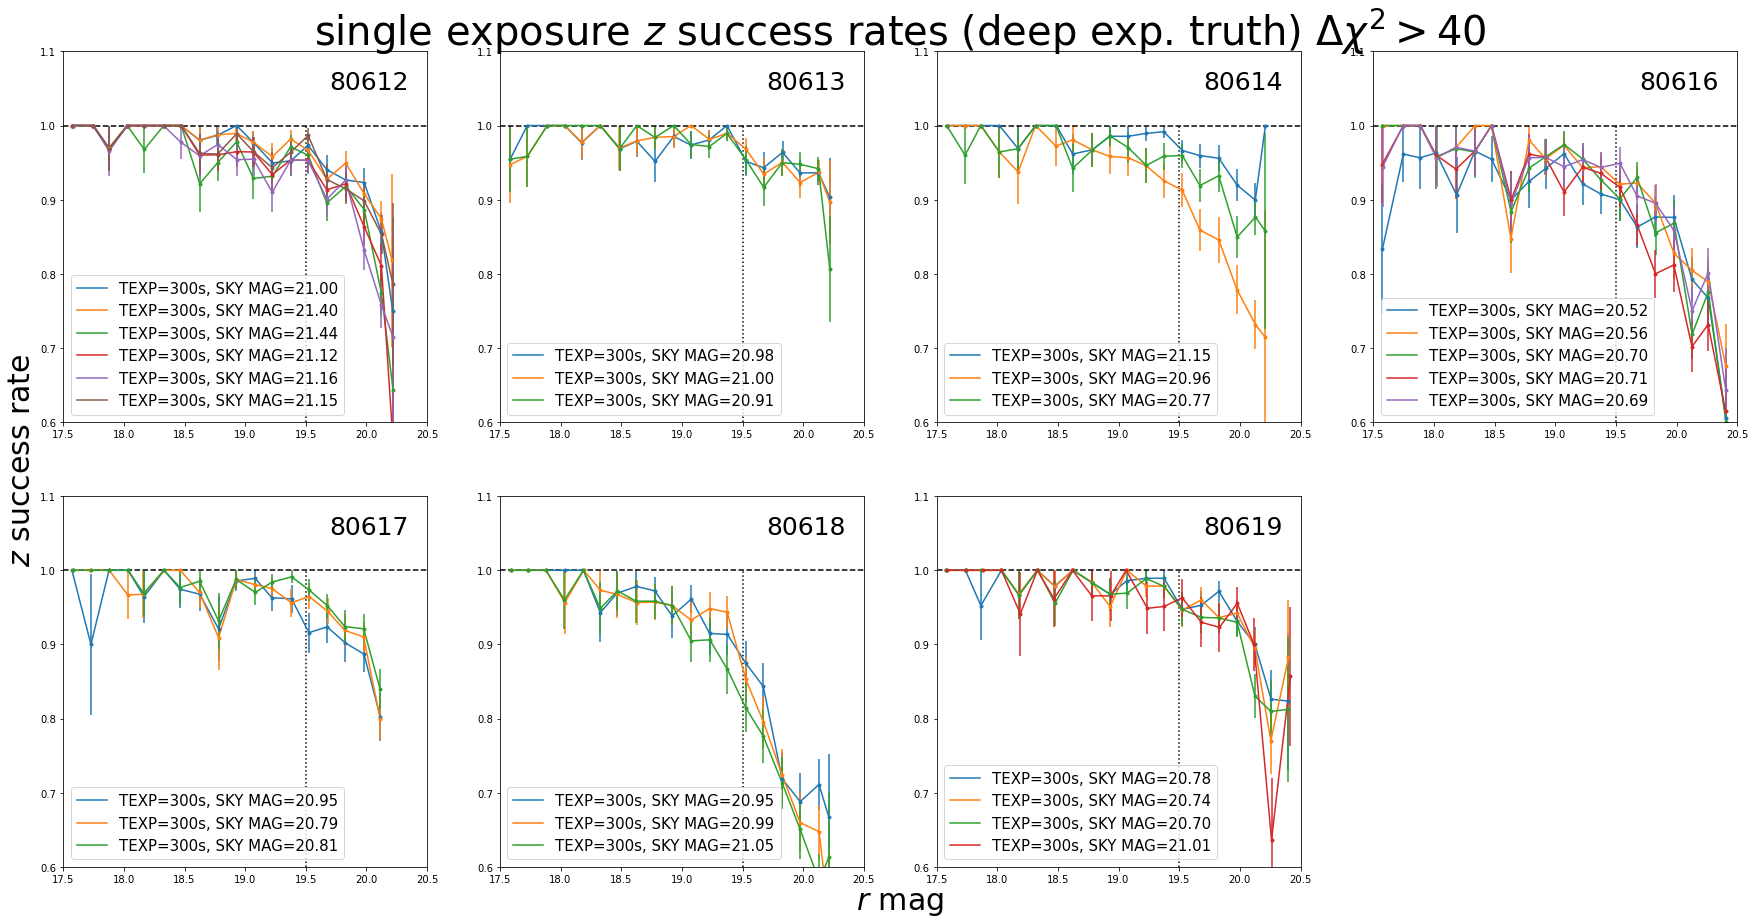

In [19]:
fig = plt.figure(figsize=(30,15))
for i, zss, iexps in zip(range(len(iexps_tiles)), zss_tiles, iexps_tiles): 
    sub = fig.add_subplot(2,4,i+1)
    nexp = 0
    sub.plot([17.5, 20.5], [1., 1.], c='k', ls='--')
    sub.vlines(19.5, 0.6, 1.0, color='k', linestyle=':')
    for zs, iexp in zip(zss, iexps): 
        r_mid, zs, zs_err = zs
        sub.errorbar(r_mid, zs, yerr=zs_err, fmt='.C%i' % nexp)
        sub.plot(r_mid, zs, c='C%i' % nexp, 
                 label=r'TEXP=%.fs, SKY MAG=%.2f' % #\nMOON ILL=%.1f,SEP=%.f,ALT=%.f,AIRMASS=%.1f' % 
                 (exps['EXPTIME'][iexp], 
                  exps['GFA_SKY_MAG_AB_MED'][iexp]))#, exps['GFA_MOON_ILLUMINATION_MED'][iexp], exps['GFA_MOON_SEP_DEG_MED'][iexp], 90.-exps['GFA_MOON_ZD_DEG_MED'][iexp], exps['GFA_AIRMASS_MED'][iexp]))
        nexp += 1
        sub.legend(loc='lower left', fontsize=15)
    sub.text(0.95, 0.95, str(exps['TILEID'][iexp][0]), transform=sub.transAxes, ha='right', va='top', fontsize=25) 
    sub.set_xlim(17.5, 20.5)
    sub.set_ylim(0.6, 1.1)
bkgd = fig.add_subplot(111, frameon=False)
bkgd.set_xlabel('$r$ mag', fontsize=30)
bkgd.set_ylabel('$z$ success rate', fontsize=30)
bkgd.set_title('single exposure $z$ success rates (deep exp. truth) $\Delta \chi^2 > 40$', fontsize=40)
bkgd.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)